In [1]:
#Import relevant libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats import shapiro 

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lager-coboh-20212022-jcdep/Lager_CO-Boh_enjeu-pH_sep2022.csv


# Exploration of pH variations in lagers brewed with two strains from Labo Solution yeasts
---
## Dataset :
Beers brewed from 2 different locations, with 2 different types of lager yeast strains. Data consists of post-boil pH (pre-yeast), post-pitch pH (post-yeast addition) and final pH witouth any dry-hopping :
<div class="alert alert-block alert-info">
<b>Fact: </b> We use pre dry-hopping (DH) pH because cold addition of hops is known to increase the pH of the beer. It will be then irrelevant to compare beers that have a different cold-hopping regime : 
<ul> 
    <li><a href="http://www2.uwstout.edu/content/lib/thesis/2014/2014schmickm.pdf">Dry Hopping and its Effect on Beer pH (Shmick 2014)</a></li>
    <li><a href="https://www.hopsteiner.com/wp-content/uploads/2016/06/2016-05_TS_PH.pdf">Hopsteiner Technical Newsletter</a></li>
    <li><a href="http://scottjanish.com/a-look-at-ph-in-hoppy-beers/">A look at pH in hoppy beers (Janish 2020 blog post)</a></li>
</ul>
</div>

## Data collection :
pH readings taken at 15-25 C with ThermoFisher Orion A111 or Hanna Edge pH meter. Gravity readings with either traditional hydrometer or EasyDens (Anton Paar)

## Data types : 
Categorical, numerical and transformed/computed.

---

In [2]:
# Import data and set proper header for dataframe
df = pd.read_csv("../input/lager-coboh-20212022-jcdep/Lager_CO-Boh_enjeu-pH_sep2022.csv",header=4)

# Lookup median for diff pitch and diff total to help later set categorical var
df.median(axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


FV                           5.000
# brassin                  717.000
Gen                          1.000
Post-Boil pH                 5.330
Post-pitch pH (FV)           5.045
Final (pre-DH)               4.360
diff pitch pH               -0.170
diff Total pH               -1.005
Specialty Torref. malts      0.000
OG (P)                      11.900
dtype: float64

## Transform diff-pitch (Post-boil pH - post-pitch pH) into categorical data
**Labels :**
- |diff pitch pH| >= 0.2 = big_shift_pitch
- |diff pitch pH| < 0.2 = small_shift_pitch

In [3]:
def label_diff_pitch(row):
    if row['diff pitch pH'] <= -0.2 :
        return 'big_shift_pitch'
    elif row['diff pitch pH'] > -0.2 :
        return 'small_shift_pitch'
    else :
        return 'NA'
# Check for proper function behavior
lab_diffpitch = df.apply(lambda row: label_diff_pitch(row), axis=1)
#lab_diffpitch.head()
# Apply to df and create column
df.insert(12, "label_diff_pitch", lab_diffpitch)


## Transform diff total pH (Post-boil pH - final pH) into categorical data
**Labels :**
- |diff tot pH| >= 1 = big_shift_tot
- |diff tot pH| < 1 = small_shift_tot

In [4]:
def label_diff_tot(row):
    if row['diff Total pH'] <= -1 :
        return 'big_shift_tot'
    elif row['diff Total pH'] > -1 :
        return 'small_shift_tot'
    else :
        return 'NA'
# Check for proper function behavior
lab_difftot = df.apply(lambda row: label_diff_tot(row), axis=1)
#lab_difftot.head()

# Apply to df and create column
df.insert(14, "label_diff_tot", lab_difftot)

## Group Generations in 2 relevant categories :
**Labels :**
- Gen = 0 -> G0
- Gen = range(1,5) > G1-to-G4

In [5]:
def label_gen(row):
    if row['Gen'] == 0 :
        return 'G0'
    elif row['Gen'] >= 1 :
        return 'G1-to-G4'
    else :
        return 'NA'
# Check for proper function behavior
lab_gen = df.apply(lambda row: label_gen(row), axis=1)
# Apply to df and create column
df.insert(7,"label_gen",lab_gen)
df

,Lieu,Date brassin,FV,Bière,# brassin,Levure,Gen,label_gen,Tag,Post-Boil pH,Post-pitch pH (FV),Final (pre-DH),diff pitch pH,label_diff_pitch,diff Total pH,label_diff_tot,# lot levure,Specialty Torref. malts,OG (P)
0,Dépôt,2022-09-14,8,TMB,1750,Boh,0,G0,Dépôt-TMB-1750-Boh-0,5.26,5.12,4.23,-0.14,small_shift_pitch,-1.03,big_shift_tot,NaN,False,11.9
1,Dépôt,2022-08-24,9,Gil,1740,Boh,0,G0,Dépôt-Gil-1740-Boh-0,5.09,4.99,4.41,-0.10,small_shift_pitch,-0.68,small_shift_tot,22529,True,17.4
2,Dépôt,2022-08-24,8,VA,1739,Boh,0,G0,Dépôt-VA-1739-Boh-0,5.42,5.25,4.36,-0.17,small_shift_pitch,-1.06,big_shift_tot,22529,True,11.2
3,Dépôt,2022-07-27,8,TMB,1721,Boh,0,G0,Dépôt-TMB-1721-Boh-0,5.48,5.41,4.64,-0.07,small_shift_pitch,-0.84,small_shift_tot,22219,False,11.9
4,Dépôt,2022-06-09,9,She,1694,Boh,0,G0,Dépôt-She-1694-Boh-0,5.33,5.17,3.97,-0.16,small_shift_pitch,-1.36,big_shift_tot,22219,False,11.9
5,Dépôt,2022-07-29,9,Lei,1723,Boh,2,G1-to-G4,Dépôt-Lei-1723-Boh-2,5.32,5.22,4.52,-0.10,small_shift_pitch,-0.80,small_shift_tot,sib1703,False,8.6
6,Dépôt,2022-06-30,9,TMB,1707,Boh,1,G1-to-G4,Dépôt-TMB-1707-Boh-1,5.35,5.25,4.63,-0.10,small_shift_pitch,-0.72,small_shift_tot,sib1674,False,10.7
7,Dépôt,2022-06-28,8,Vie,1703,Boh,1,G1-to-G4,Dépôt-Vie-1703-Boh-1,4.86,NaN,4.57,NaN,NA,-0.29,small_shift_tot,sib1694,True,10.6
8,Dépôt,2022-05-17,9,TMB,1675,Boh,1,G1-to-G4,Dépôt-TMB-1675-Boh-1,5.31,5.29,4.74,-0.02,small_shift_pitch,-0.57,small_shift_tot,sib1653,False,11.3
9,Dépôt,2022-04-06,9,TMB,1653,Boh,0,G0,Dépôt-TMB-1653-Boh-0,5.37,5.33,4.45,-0.04,small_shift_pitch,-0.92,small_shift_tot,22046,False,12.4


# Basic categorical feature visualization
- Whole Dataframe
- brews per site
- styles brewed
- generations
- yeast type

In [6]:
# View whole dataframe
df.head()

,Lieu,Date brassin,FV,Bière,# brassin,Levure,Gen,label_gen,Tag,Post-Boil pH,Post-pitch pH (FV),Final (pre-DH),diff pitch pH,label_diff_pitch,diff Total pH,label_diff_tot,# lot levure,Specialty Torref. malts,OG (P)
0,Dépôt,2022-09-14,8,TMB,1750,Boh,0,G0,Dépôt-TMB-1750-Boh-0,5.26,5.12,4.23,-0.14,small_shift_pitch,-1.03,big_shift_tot,NaN,False,11.9
1,Dépôt,2022-08-24,9,Gil,1740,Boh,0,G0,Dépôt-Gil-1740-Boh-0,5.09,4.99,4.41,-0.10,small_shift_pitch,-0.68,small_shift_tot,22529,True,17.4
2,Dépôt,2022-08-24,8,VA,1739,Boh,0,G0,Dépôt-VA-1739-Boh-0,5.42,5.25,4.36,-0.17,small_shift_pitch,-1.06,big_shift_tot,22529,True,11.2
3,Dépôt,2022-07-27,8,TMB,1721,Boh,0,G0,Dépôt-TMB-1721-Boh-0,5.48,5.41,4.64,-0.07,small_shift_pitch,-0.84,small_shift_tot,22219,False,11.9
4,Dépôt,2022-06-09,9,She,1694,Boh,0,G0,Dépôt-She-1694-Boh-0,5.33,5.17,3.97,-0.16,small_shift_pitch,-1.36,big_shift_tot,22219,False,11.9


## Get frequency counts for pH shifts (categories) and gen (G0 vs. G1-4)

In [7]:
# For pH shifts from post-boil to post-pitch
df_diff_naless = df.dropna(subset=['diff pitch pH','diff Total pH'])
counts_dp = df_diff_naless.groupby(['Levure','label_gen','label_diff_pitch'])['label_diff_pitch'].count()
counts_dp.to_frame()

label_diff_pitch
Levure label_gen label_diff_pitch                   
Boh    G0        small_shift_pitch                 6
       G1-to-G4  small_shift_pitch                 5
LCO    G0        big_shift_pitch                   5
                 small_shift_pitch                 1
       G1-to-G4  big_shift_pitch                   9
                 small_shift_pitch                 3

In [8]:
# For pH shifts from post-boil to total (pre-DH)
counts_tp = df_diff_naless.groupby(['Levure','label_gen','label_diff_tot'])['label_diff_tot'].count()
counts_tp.to_frame()

label_diff_tot
Levure label_gen label_diff_tot                 
Boh    G0        big_shift_tot                 3
                 small_shift_tot               3
       G1-to-G4  big_shift_tot                 1
                 small_shift_tot               4
LCO    G0        big_shift_tot                 5
                 small_shift_tot               1
       G1-to-G4  big_shift_tot                 7
                 small_shift_tot               5

**Almost even distribution of number of batches brewed per site, but...**

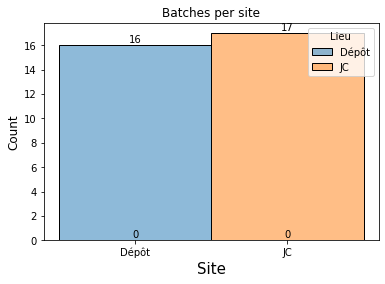

In [9]:
# Batches per site
p_site = sns.histplot(data=df, x="Lieu", hue="Lieu")
p_site.set(title = "Batches per site")
p_site.set_xlabel("Site", fontsize = 15)
p_site.set_ylabel("Count", fontsize = 12)
# label each bar in histogram
for p in p_site.patches:
 height = p.get_height() # get the height of each bar
 # adding text to each bar
 p_site.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
 s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
 ha = 'center') # sets horizontal alignment (ha) to center



**As we can see, most of the lagers brewed at JC are Sherbiere, at least in this dataset/time period**

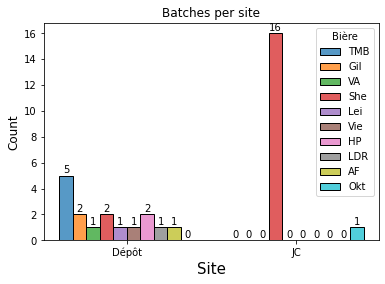

In [10]:
# Batches per site with SKUs
p_sitesku = sns.histplot(data=df, x="Lieu", hue="Bière",shrink=0.8, multiple="dodge")
p_sitesku.set(title = "Batches per site")
p_sitesku.set_xlabel("Site", fontsize = 15)
p_sitesku.set_ylabel("Count", fontsize= 12)
# label each bar in histogram
for p in p_sitesku.patches:
 height = p.get_height() # get the height of each bar
 # adding text to each bar
 p_sitesku.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
 s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
 ha = 'center') # sets horizontal alignment (ha) to center

**Different representation of generations of yeast for SKUs**

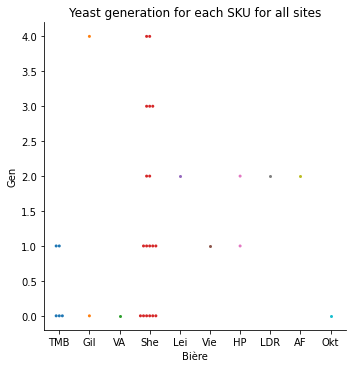

In [11]:
# Generations per SKU types
p_gensku = sns.catplot(data=df, x="Bière",y="Gen", kind="swarm", hue="Bière", s=3, )
p_gensku.set(title = "Yeast generation for each SKU for all sites")

**Now for yeast generations distributions per yeast types. LCO yeast seems more widely distribued than accros generations than Boh**

<AxesSubplot:xlabel='Levure', ylabel='Gen'>

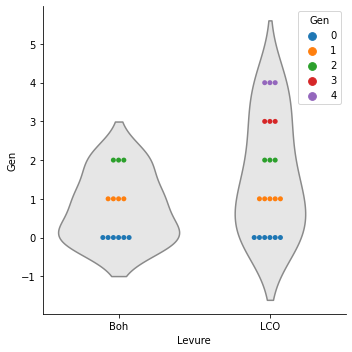

In [12]:
p_genyeast  = sns.catplot(data=df, x="Levure",y="Gen", kind="violin", dodge=True, inner=None, color=".9")
sns.swarmplot(data=df,x="Levure",y="Gen", size=5, hue="Gen")

## pH distributions and relationship to yeast type and generation

**pH distributions across 3 timepoints**<br>
- Post-boil pH seem to have a left skewed dist
- Other pH timepoints have a large standard deviation

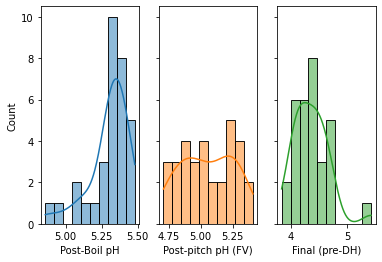

In [13]:
ph_tp = ["Post-Boil pH", "Post-pitch pH (FV)","Final (pre-DH)"]
fig, axes = plt.subplots(1,3, sharex=False,sharey=True)
ncols = len(ph_tp)
palette = itertools.cycle(sns.color_palette())

for i,t in enumerate(ph_tp):
    sns.histplot(data=df, x=t, ax=axes[i % ncols],color=next(palette),kde=True, bins=10)

<AxesSubplot:>

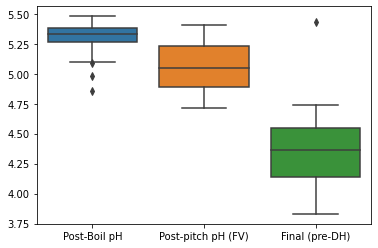

In [14]:
sns.boxplot(data=df[ph_tp])

**For this project, I won't bother with data transformation and will thus test normality for un-transformed data and then perform statistical test accordingly**

In [15]:
# Test of normality for all pH distributions with T-I error threshold of 5%

def normTest(data):
    alpha = 0.05
    for i in data :
        df_naless = (df[i]).dropna()
        stat, p = shapiro(df_naless)
        print('Statistics=%.3f, p=%.3f' % (stat, p),"for var",i)
        if p > alpha:
            print(i,'distribution looks Gaussian (fail to reject H0)\n')
        else:
            print(i,'distribution does not look Gaussian (reject H0)\n')
normTest(ph_tp)

Statistics=0.854, p=0.001 for var Post-Boil pH
Post-Boil pH distribution does not look Gaussian (reject H0)

Statistics=0.952, p=0.165 for var Post-pitch pH (FV)
Post-pitch pH (FV) distribution looks Gaussian (fail to reject H0)

Statistics=0.916, p=0.018 for var Final (pre-DH)
Final (pre-DH) distribution does not look Gaussian (reject H0)



**Since the test we want to run are based on differences from post-boil pH (and it cannot be considered to be normally distributed), we will use non-parametric methods**